In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/colabpractice/tensorflow_practice/GCN_parctice

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/colabpractice/tensorflow_practice/GCN_parctice


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GCN_layer import GCN_layer as Con
from dataloader import data_loader

In [3]:
learning_rate = 1e-3
path_content = 'cora/cora.content'
path_cite = 'cora/cora.cites'

In [4]:
from keras.api._v2.keras import activations
from keras.src.engine.functional import input_spec
class GCN(tf.keras.Model):
  def __init__(self,node_dim,fea_dim,out_dim):
    super().__init__()
    self.fea_dim = fea_dim
    self.out_dim = out_dim
    self.node_dim = node_dim

    self.con1 = Con(self.fea_dim,2048)
    self.con2 = Con(2048,self.out_dim)

    self.fla1 = tf.keras.layers.Flatten(input_shape=[self.out_dim,self.out_dim])
    self.den1 =tf.keras.layers.Dense(self.out_dim,activation='softmax')

  def call(self,inputs,support):
    print(inputs.shape,support.shape)
    hidden1 = self.con1(inputs,support)
    unflattened = self.con2(hidden1,support)
    undensed = self.fla1(unflattened)
    output =self.den1(undensed)
    return output

In [5]:
dataloader = data_loader(path_content=path_content,path_cite=path_cite)
X,Y,support =dataloader.get_data()
print(X.shape,Y.shape,support.shape)

(2708, 1433) (2708, 7) (2708, 2708)


In [6]:
class GCN(tf.keras.Model):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(GCN, self).__init__()
    self.gcn1 = Con(fea_dim=input_dim, out_dim=hidden_dim, activation='relu')
    self.gcn2 = Con(fea_dim=hidden_dim, out_dim=output_dim)
    self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, inputs):
    x, support = inputs
    x = self.dropout(x)
    x = self.gcn1([x, support])
    x = self.dropout(x)
    x = self.gcn2([x, support])
    return x

In [7]:
import matplotlib.pyplot as plt

input_dim = 1433
hidden_dim = 16
output_dim = 7
epochs = 100

# 实例化模型
model = GCN(input_dim, hidden_dim, output_dim)

# 选择优化器和损失函数
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
accuracy_fn = tf.keras.metrics.CategoricalAccuracy()

# 用于记录每个epoch的损失和精度
losses = []
accuracies = []

# 训练循环
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = model([X, support])
        loss = loss_fn(Y, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    acc = accuracy_fn(Y, predictions).numpy()
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}, Accuracy: {acc}")

    losses.append(loss.numpy())
    accuracies.append(acc)

Epoch 1, Loss: 1.9343892335891724, Accuracy: 0.20088626444339752
Epoch 2, Loss: 1.8300186395645142, Accuracy: 0.3018833100795746
Epoch 3, Loss: 1.7112802267074585, Accuracy: 0.3631216287612915
Epoch 4, Loss: 1.5830873250961304, Accuracy: 0.4134047329425812
Epoch 5, Loss: 1.4582291841506958, Accuracy: 0.45243722200393677
Epoch 6, Loss: 1.3439942598342896, Accuracy: 0.4809207320213318
Epoch 7, Loss: 1.2419675588607788, Accuracy: 0.5026904344558716
Epoch 8, Loss: 1.1499321460723877, Accuracy: 0.5199870467185974
Epoch 9, Loss: 1.0654455423355103, Accuracy: 0.5345888733863831
Epoch 10, Loss: 0.9867289662361145, Accuracy: 0.5476735830307007
Epoch 11, Loss: 0.9128966927528381, Accuracy: 0.5604941844940186
Epoch 12, Loss: 0.8439449071884155, Accuracy: 0.5738860368728638
Epoch 13, Loss: 0.7801954746246338, Accuracy: 0.5880866050720215
Epoch 14, Loss: 0.7218600511550903, Accuracy: 0.6032390594482422
Epoch 15, Loss: 0.6688061356544495, Accuracy: 0.6190546751022339
Epoch 16, Loss: 0.62105876207351

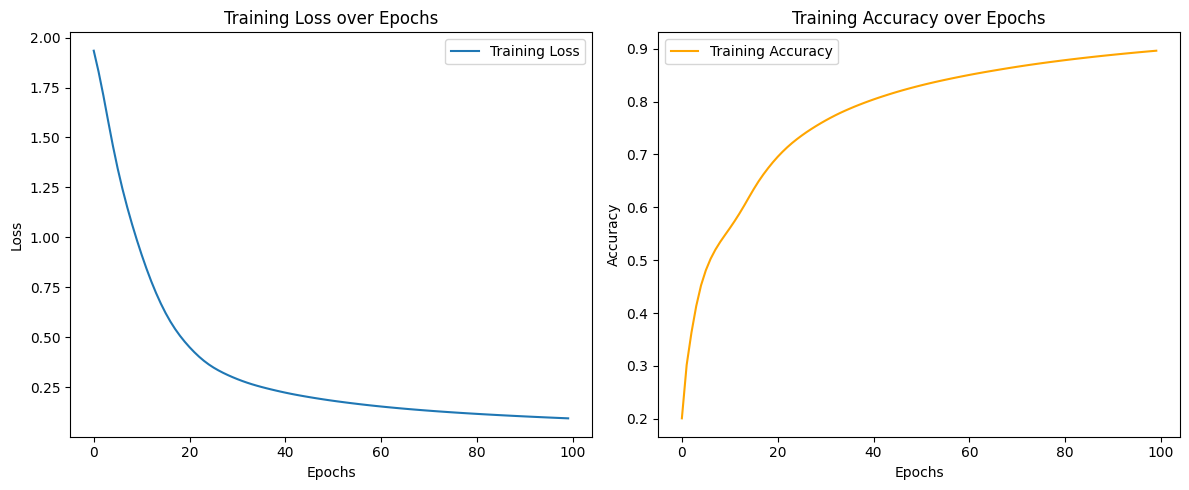

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# model = GCN(X.shape[0],support.shape[-1],Y.shape[-1])
class GCN_layer(tf.keras.layers.Layer):
  def __init__(self, fea_dim: int, out_dim: int, support, activation=None):
    super(GCN_layer, self).__init__()
    self.fea_dim = fea_dim
    self.out_dim = out_dim
    self.support = support
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    self.wei = self.add_weight(name='wei',
                  shape=[self.fea_dim, self.out_dim],
                  initializer='glorot_uniform')

  def call(self, inputs):
    x = tf.cast(inputs, dtype=tf.float32)
    support = tf.cast(self.support, dtype=tf.float32)
    H_t = tf.matmul(support, x)
    output = tf.matmul(H_t, self.wei)

    if self.activation is not None:
        output = self.activation(output)

    return output


In [10]:
model = tf.keras.Sequential([
    GCN_layer(fea_dim=1433, out_dim=7, support=support, activation='relu')
])

model.compile(optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [11]:
batch_size = 2708
epochs = 100

history = model.fit(X, Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X, Y))

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 1.9434 - accuracy: 0.1658 - val_loss: 1.9382 - val_accuracy: 0.1953
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 1.9411 - accuracy: 0.1769 - val_loss: 1.9357 - val_accuracy: 0.2079
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 1.9408 - accuracy: 0.1821 - val_loss: 1.9333 - val_accuracy: 0.2134
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 1.9368 - accuracy: 0.1998 - val_loss: 1.9310 - val_accuracy: 0.2216
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.9325 - accuracy: 0.2290 - val_loss: 1.9287 - val_accuracy: 0.2341
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 1.9304 - accuracy: 0.2290 - val_loss: 1.9265 - val_accuracy: 0.2374
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.9287 - accuracy: 0.2445 - val_loss: 1.9243 - val_accuracy: 0.2478
Epoch 8/100
1/1 [=================

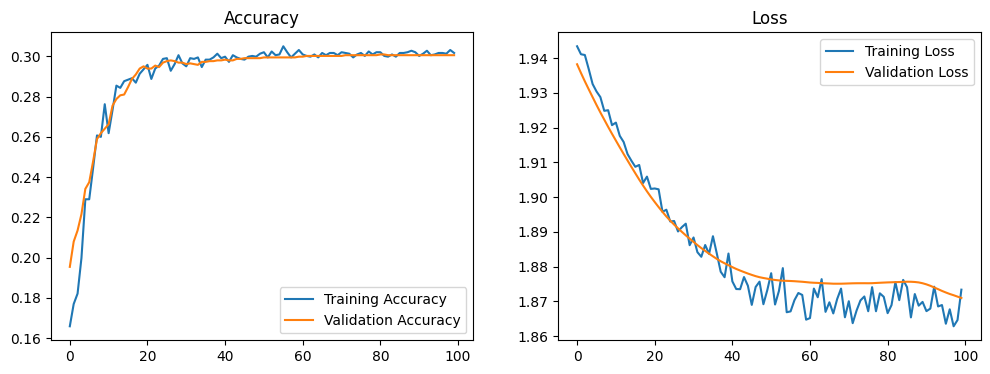

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [13]:
model = tf.keras.Sequential([
  GCN_layer(fea_dim=1433, out_dim=16, support=support, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  GCN_layer(fea_dim=16, out_dim=7, support=support)
])

model.compile(optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
batch_size = 2708
epochs = 100

history = model.fit(X, Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X, Y))

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 1.9491 - accuracy: 0.1178 - val_loss: 1.9400 - val_accuracy: 0.1374
Epoch 2/100
1/1 [==============================] - 1s 784ms/step - loss: 1.9399 - accuracy: 0.1629 - val_loss: 1.9296 - val_accuracy: 0.1965
Epoch 3/100
1/1 [==============================] - 1s 797ms/step - loss: 1.9337 - accuracy: 0.2042 - val_loss: 1.9195 - val_accuracy: 0.2670
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 1.9252 - accuracy: 0.2541 - val_loss: 1.9096 - val_accuracy: 0.2969
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.9177 - accuracy: 0.2803 - val_loss: 1.9002 - val_accuracy: 0.3150
Epoch 6/100
1/1 [==============================] - 1s 812ms/step - loss: 1.9101 - accuracy: 0.2914 - val_loss: 1.8911 - val_accuracy: 0.3161
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.9053 - accuracy: 0.2969 - val_loss: 1.8824 - val_accuracy: 0.3087
Epoch 8/100
1/1 [======

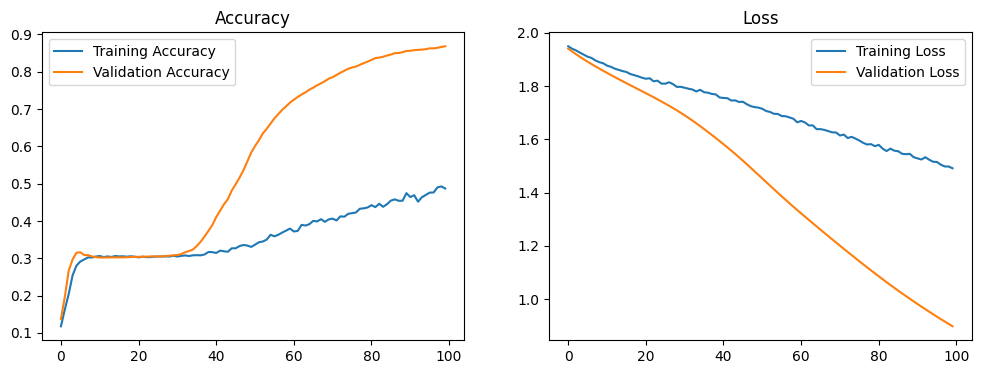

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()